
# ML-модель для опредения рыночной цены автомобиля


In [402]:
from IPython.display import Image
display(Image(url='https://million-wallpapers.ru/wallpapers/4/72/18038241282065478898/starinnyj-gonochnyj-avtomobil-na-fone-goroda.jpg', width = 1000))

---
## Введение


Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. 

**Цель исследования:** нужно построить модель для определения стоимости автомобиля.  

*Заказчику важны*:  
* качество предсказания;
* скорость предсказания;
* время обучения.

**Признаки:**
* `DateCrawled` — дата скачивания анкеты из базы
* `VehicleType` — тип автомобильного кузова
* `RegistrationYear` — год регистрации автомобиля
* `Gearbox` — тип коробки передач
* `Power` — мощность (л. с.)
* `Model` — модель автомобиля
* `Kilometer` — пробег (км)
* `RegistrationMonth` — месяц регистрации автомобиля
* `FuelType` — тип топлива
* `Brand` — марка автомобиля
* `NotRepaired` — была машина в ремонте или нет
* `DateCreated` — дата создания анкеты
* `NumberOfPictures` — количество фотографий автомобиля
* `PostalCode` — почтовый индекс владельца анкеты (пользователя)
* `LastSeen` — дата последней активности пользователя  

**Целевой признак**
`Price` — цена (евро)

## Подготовка данных

### Первичное ознакомление

In [403]:
# Перед началом работы импортируем необходимые библиотеки:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sweetviz as sv
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder

In [404]:
# Отключаем предупреждения "Анаконды":
import warnings 
warnings.filterwarnings('ignore')
get_ipython().run_line_magic('config', "InlineBackend.figure_format = 'svg'")

# Увеличим дефолтный размер графиков:
from pylab import rcParams
rcParams['figure.figsize'] = 10,5


# Пропишем путь к датасету:
try:
    df = pd.read_csv('/datasets/autos.csv')
except:
    df = pd.read_csv('autos.csv')

In [405]:
# Посмотрим на данные с "головы" и с "хвоста"
display(df.head(),df.tail())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26
354368,2016-03-20 19:41:08,3400,wagon,2002,manual,100,golf,150000,6,gasoline,volkswagen,NaN,2016-03-20 00:00:00,0,40764,2016-03-24 12:45:21


In [406]:
df.shape

(354369, 16)

In [407]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [408]:
df.columns = df.columns.str.lower()
df.columns

Index(['datecrawled', 'price', 'vehicletype', 'registrationyear', 'gearbox',
       'power', 'model', 'kilometer', 'registrationmonth', 'fueltype', 'brand',
       'notrepaired', 'datecreated', 'numberofpictures', 'postalcode',
       'lastseen'],
      dtype='object')

In [410]:
#report.show_html('common analysis.html')

In [411]:
# методом rename() приведем названия столбцов к более удобному виду, разделенных нижней чертой: 
df = df.rename(
    columns={
        'datecrawled': 'date_crawled',
        'vehicletype' : 'vehicle_type',
        'registrationyear' : 'registration_year',
        'registrationmonth' : 'registration_month',
        'fueltype' : 'fuel_type',
        'notrepaired' : 'not_repaired', 
        'datecreated' : 'date_created',
        'numberofpictures' : 'number_of_pictures',
        'postalcode' : 'postal_code',
        'lastseen' : 'last_seen'        
   }
)
#проверим обновления:
df.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


### Обработка пропусков

In [412]:
# Получим сведения о пропусках:
df.isna().sum()

date_crawled              0
price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type             32895
brand                     0
not_repaired          71154
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

Пропуски содержатся в столбцах с категориальными значениями - тип кузова, тип коробки передач, название модели, вид топлива, а также сведения о проведенном ремонте. Данные пропуски нельзя заменить на медианное или среднее значение. Однако, мы можем их заменить на значение моды, т.е. на самое распространённое. Для этого созданим небольшую функцию.

In [413]:
def popular(x):
    mode = x.mode()
    if len(mode) > 0:
        return mode[0]

In [414]:
# Сгруппируем датасет по столбцам бренда и цены:
gb = df.groupby(['brand', 'price'])

# Теперь заполним пропуски на полулярное значение методом transform(): 
df['model'] = df['model'].fillna(gb['model'].transform(popular))
df['vehicle_type'] = df['vehicle_type'].fillna(gb['vehicle_type'].transform(popular))
df['gearbox'] = df['gearbox'].fillna(gb['gearbox'].transform(popular))
df['fuel_type'] = df['fuel_type'].fillna(gb['fuel_type'].transform(popular))
df['not_repaired'] = df['not_repaired'].fillna(gb['not_repaired'].transform(popular))

In [415]:
df.isna().sum()

date_crawled             0
price                    0
vehicle_type           938
registration_year        0
gearbox                712
power                    0
model                 3720
kilometer                0
registration_month       0
fuel_type              862
brand                    0
not_repaired          2050
date_created             0
number_of_pictures       0
postal_code              0
last_seen                0
dtype: int64

В столбцах остались пропуски, которые не получилось сгруппировать на ценам. В то же время, их количество некретично, поэтому можем их удалить методом dropna()

In [416]:
#методом dropna() удалим сторочки с пропусками
df.dropna(inplace=True)

#Посмотрим еще раз, все ли пропуски удалены:
df.isna().sum()

date_crawled          0
price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
not_repaired          0
date_created          0
number_of_pictures    0
postal_code           0
last_seen             0
dtype: int64

### Подготовка признаков

Перед началом обучения необходимо подготовить признаки (информация по опреденному параметру, т.е. в стобце). Как можно увидеть, в таблице присутствуют несколько столбцов с числовыми данными, которые для обучения нам не понадобяться.

In [417]:
data = df.drop(['date_crawled', 'registration_month',
               'date_created', 'number_of_pictures', 'postal_code', 'last_seen' ], axis=1).copy()
data.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,not_repaired
0,480,small,1993,manual,0,golf,150000,petrol,volkswagen,no
1,18300,coupe,2011,manual,190,a6,125000,gasoline,audi,yes
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes


Text(0.5, 1.0, 'Распределение по ценам')

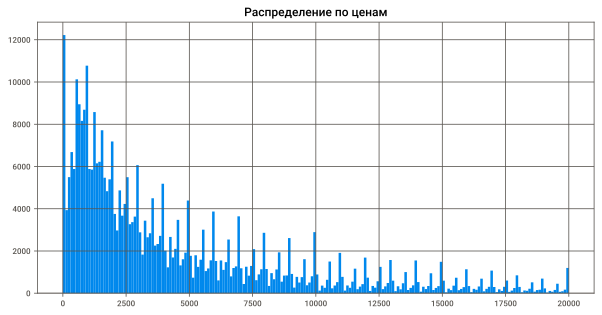

In [418]:
data["price"].hist(bins=200)
plt.title('Распределение по ценам')

По построенному графику можем увидеть, что у огромного количества автомобилей цена составляет 0 руб. Это может быть связано с тем, что анкеты ориентированы на торг с покупателем. Однако, для создания ценовой модели такие значения могут помешать ее реализации.  

Теперь посмотрим на значения мощности в столбце `['power']`. Мощность измеряется в лошадиных силах, поэтому данная величина является непрерывной. Здесь обычная гистограмма частотностей не может быть применена.

Text(0.5, 1.0, 'Распределение по мощности')

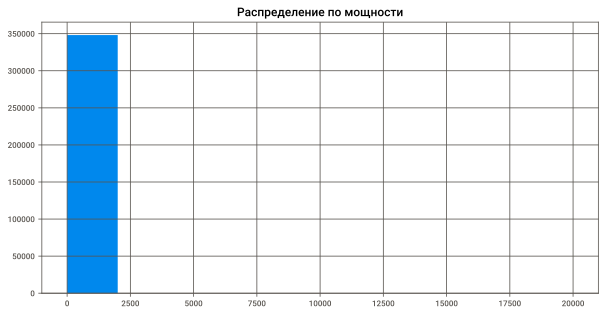

In [419]:
data.power.hist(bins=10)
plt.title('Распределение по мощности')

Поэтому разделим значения по интервалам, которые передадим аргументом в параметр `bins`

Text(0.5, 1.0, 'Распределение по мощности')

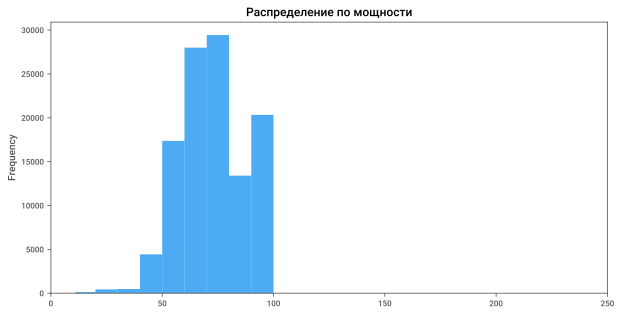

In [420]:
data['power'].plot(kind='hist', bins=[11, 20, 30, 40, 50, 60, 70, 80, 90, 100], alpha=0.7, xlim=(0, 250))
plt.title('Распределение по мощности')

Посмотрим на значения годов регистрации автомобиля

In [421]:
data.registration_year.unique()

array([1993, 2011, 2001, 2008, 1995, 2004, 1980, 2014, 1998, 2005, 1910,
       2016, 2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994,
       1991, 1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985,
       1989, 2015, 1982, 1976, 1983, 1973, 1111, 1969, 1971, 1987, 1988,
       1970, 1986, 1965, 1945, 1974, 1955, 1978, 1979, 1972, 1968, 1977,
       1961, 1960, 1966, 1975, 1963, 1954, 1967, 1956, 1000, 9999, 1500,
       2200, 1964, 3000, 2066, 1940, 1962, 2019, 1937, 1951, 1800, 1959,
       1953, 1958, 9000, 2900, 5900, 5911, 1933, 1400, 5000, 1950, 4000,
       8000, 1952, 1200, 8500, 1932, 3700, 1942, 1935, 1234, 1936, 6500,
       1957, 1923, 2290, 2500, 1930, 1001, 7000, 1929, 1943, 1934, 1938,
       1688, 2800, 1928, 1919, 5555, 5600, 1039, 6000, 1948, 2222, 1931,
       4500, 1602, 7800, 9229, 1947, 1927, 7100, 1300, 8200, 7500, 1600],
      dtype=int64)

Среди значений года выпуска присутствует большой разброс. Некоторые значения имеют аномальный характер, такие как: 1001, 1600, 9229. Методом `query` создадим отдельный срез, в котором будет только года из актуального периода.

Text(0.5, 1.0, 'Распределение по годам регистрации')

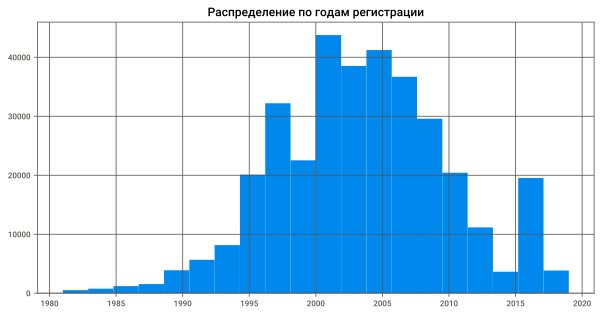

In [422]:
x = data.query('1980 < registration_year < 2020')
x ['registration_year'].hist(bins=20)
plt.title('Распределение по годам регистрации')

Изучив полученные данные, построим на их основе очищенный от вбросов срез.

In [425]:
actual_data = data.query('1980 < registration_year < 2020 and price != 0' )
actual_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 335060 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              335060 non-null  int64 
 1   vehicle_type       335060 non-null  object
 2   registration_year  335060 non-null  int64 
 3   gearbox            335060 non-null  object
 4   power              335060 non-null  int64 
 5   model              335060 non-null  object
 6   kilometer          335060 non-null  int64 
 7   fuel_type          335060 non-null  object
 8   brand              335060 non-null  object
 9   not_repaired       335060 non-null  object
dtypes: int64(4), object(6)
memory usage: 28.1+ MB


Существует гипотеза о том, что возраст машины влияет на ее ценобразование. Проверим это путём разбивки на возрастные группы.

In [426]:
#создадим функцию для раздела по году регистрации:
def reg_group(row):
    year = row['registration_year']
    if 2015 <= year <= 2021:
        return 'новая'
    if 2010 <= year <= 2014:
        return 'средне-новая'
    if 2000 <= year <= 2009:
        return 'старая'
    else:
        return 'ретро'

In [427]:
actual_data['registration_group'] = actual_data.apply(reg_group, axis=1)
actual_data['registration_group'].value_counts()

старая          186014
ретро            92076
средне-новая     33791
новая            23179
Name: registration_group, dtype: int64

In [428]:
categorical_features = ['vehicle_type', 'gearbox',  
                        'model', 'fuel_type', 'brand', 
                        'not_repaired', 'registration_year',
                       'registration_group']

In [429]:
actual_data[categorical_features] = actual_data[categorical_features].astype('category')
actual_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 335060 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   price               335060 non-null  int64   
 1   vehicle_type        335060 non-null  category
 2   registration_year   335060 non-null  category
 3   gearbox             335060 non-null  category
 4   power               335060 non-null  int64   
 5   model               335060 non-null  category
 6   kilometer           335060 non-null  int64   
 7   fuel_type           335060 non-null  category
 8   brand               335060 non-null  category
 9   not_repaired        335060 non-null  category
 10  registration_group  335060 non-null  category
dtypes: category(8), int64(3)
memory usage: 13.1 MB


In [430]:
def split_data(data, target_column):
    return data.drop(columns=[target_column], axis=1), data[target_column]

In [431]:
features, target = split_data(actual_data,'price')

features_df, features_valid, target_df, target_valid = train_test_split(features, 
                                                                        target, 
                                                                        test_size=0.20, 
                                                                        random_state=42)

features_train, features_test, target_train, target_test = train_test_split(features_df, 
                                                                            target_df, 
                                                                            test_size=0.25, 
                                                                            random_state=42)

print('Объктов в train:', len(features_train))
print('Объктов в valid:', len(features_valid))
print('Объктов в test:', len(features_test))
print('Сумма объектов:', len(features_train) + len(features_test) + len(features_valid))
print()
print('Объектов всего:', len(data))

Объктов в train: 201036
Объктов в valid: 67012
Объктов в test: 67012
Сумма объектов: 335060

Объектов всего: 348267


## Обучение моделей

### LightGBM

In [432]:
%%time
import time
time_start = time.time()
model = LGBMRegressor(random_state=393, learning_rate=0.3, nam_leaves=50)
model.fit(features_train, target_train)
time_lgbm_fit = time.time() - time_lgbm_fit
predict_valid = model.predict(features_valid)
time_lgbm_predict = time.time() - time_start
result_lgbm = mean_squared_error(target_valid, predict_valid) ** 0.5
print('RMSE:', result_lgbm)
print('Время обучения:', time_lgbm_fit)
print('Скорость предсказания', time_lgbm_predict)

[LightGBM] [Warning] Unknown parameter: nam_leaves
RMSE: 1544.4669303092162
Время обучения: 1474.4395463466644
Скорость предсказания 48.94538187980652
Wall time: 50 s


### CatBoost

In [ ]:
grid = [{'iterations': [180, 200, 20],
        'depth': [ 6, 10, 2]}]

In [ ]:
%%time
regressor = CatBoostRegressor(random_state=393,cat_features=cat_features,logging_level='Silent') 
clf = GridSearchCV(regressor, grid, scoring='neg_mean_squared_error',n_jobs = -1,cv=3)
clf.fit(features_train,target_train)

In [ ]:
clf.best_params_

In [ ]:
time_start = time.time()
model = CatBoostRegressor(random_state=393,
                          cat_features=categorical_features, 
                          logging_level='Silent',
                          depth=10, 
                          iterations=200)
model.fit(features_train,target_train)
time_cat_fit = time.time() - time_start
predict_valid = model.predict(features_valid)
time_cat_predict = time.time() - time_cat_fit
result_cat = mean_squared_error(target_valid, predict_valid) ** 0.5
print('RMSE:', result_cat)
print('Время обучения:', time_cat_fit)
print('Скорость предсказания', time_cat_predict)

### Линейная регрессия

In [433]:
actual_data.columns

Index(['price', 'vehicle_type', 'registration_year', 'gearbox', 'power',
       'model', 'kilometer', 'fuel_type', 'brand', 'not_repaired',
       'registration_group'],
      dtype='object')

In [196]:
# Занесем категориальные признаки в отдельную переменную:
ohe_columns = ['vehicle_type', 'gearbox', 'model', 
               'fuel_type', 'brand', 
               'not_repaired', 'registration_year',
              'registration_group']

# кодируем признаки
ohe = pd.get_dummies(actual_data[ohe_columns], drop_first=True)

# Удалим ненужные столбцы
actual_data = actual_data.drop(['vehicle_type', 'gearbox', 'registration_year', 'model', 'fuel_type', 'brand', 'not_repaired', 'registration_group'], axis=1)
actual_data.head()

,price,power,kilometer
0,480,0,150000
1,18300,190,125000
3,1500,75,150000
4,3600,69,90000
5,650,102,150000


In [197]:
df_ohe = pd.concat([actual_data, ohe], axis=1)
df_ohe

,price,power,kilometer,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,vehicle_type_wagon,...,registration_year_2013,registration_year_2014,registration_year_2015,registration_year_2016,registration_year_2017,registration_year_2018,registration_year_2019,registration_group_ретро,registration_group_средне-новая,registration_group_старая
0,480,0,150000,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,18300,190,125000,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,1500,75,150000,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,3600,69,90000,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
5,650,102,150000,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354362,3200,225,150000,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
354363,1150,0,150000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
354366,1199,101,125000,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
354367,9200,102,150000,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [199]:
features, target = split_data(df_ohe, 'price')

features_df, features_valid, target_df, target_valid = train_test_split(features, 
                                                                        target, 
                                                                        test_size=0.20, 
                                                                        random_state=42)

features_train, features_test, target_train, target_test = train_test_split(features_df, 
                                                                            target_df, 
                                                                            test_size=0.25, 
                                                                            random_state=42)

print('Объктов в train:', len(features_train))
print('Объктов в valid:', len(features_valid))
print('Объктов в test:', len(features_test))
print('Сумма объектов:', len(features_train) + len(features_test) + len(features_valid))

Объктов в train: 201036
Объктов в valid: 67012
Объктов в test: 67012
Сумма объектов: 335060


In [200]:
time_start = time.time()
model = LinearRegression()
model.fit(features_train, target_train)
time_linear_fit = time.time() - time_start
predict_valid = model.predict(features_valid)
time_linear_predict = time.time() - time_linear_fit
result_linear = mean_squared_error(target_valid, predict_valid) ** 0.5
print('RMSE линейной регресси:', result_linear)
print('Время обучения:', time_linear_fit)
print('Скорость предсказания', time_linear_predict)

RMSE линейной регресси: 2211.8089078214753
Время обучения: 9.22031831741333
Скорость предсказания 1642238502.2432892


## Анализ моделей

Для более наглядного сравнения, создадим сводную таблицу по каждой модели с указанием качества предсказания, скорости и времени обучения.

In [330]:
data=data = [['Качество предсказаний', result_lgbm, result_cat, result_linear], 
             ['Скорость предсказаний', time_lgbm_predict, time_cat_predict, time_linear_predict],
            ['Время обучения', time_lgbm_fit, time_cat_fit, time_linear_fit]]
columns = ['Параметр', 'LightGBM', 'CatBoost', 'Linear_regression']
table = pd.DataFrame(data = data, columns = columns )

table

,Параметр,LightGBM,CatBoost,Linear_regression
0,Качество предсказаний,2042.595398,2.091969e+03,2.329390e+03
1,Скорость предсказаний,0.489617,1.642169e+09,1.642169e+09
2,Время обучения,336.388515,3.572097e+01,9.570212e+00


## Общий вывод
Для выполнения поставленной задачи был проведён предварительный анализ, который показал, что таблица содержит более 350 тыс. наблюдений о характеристиках и стоимости автомоблией. 

Было установлено, что строки содержат пропуски в столбцах с категориальными значениями. Обнаруженные пропуски были заменены на значения моды в сгруппированном датасете по марке автомобилей и их ценам. Незначительное количество оставшихся пропусков было удалено из датасета.

Кроме того, в данных присутствовали аномальные значения, такие как регистрации транспортого средства в 1001 году или цена автомобиля, равная нулю. Чтобы избежать некорректные значения, был создан срез данных с регистрацией от 1980 по 2021 год и ценой, не равной нулю. 

Учитывая, что в разные года регистрация по-своему влияла на цену автомобиля, данные были разбиты на четыре категории: новая, средне-новая, старая и ретро. 

Таким образом, для обучения были созданы три модели машинного обучения: LightGBM, CatBoost и линейная регрессия. При сравнении моделей по качеству предсказаний лучший результат дал CatBoost. Результат чуть ниже показал LightGBM. В то же время, LightGBM имеет большую скорость обучения. Поэтому при создании приложения, определяющего цены, рекомендуется использовать именно LightGBM, поскольку у него самые оптимальные характеристики.


## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей